# Homework 3: Reproducibility in Climate Studies

## The West Coast Heat Wave
### Question 6 [10 points]

Reproduce one of the images in Figure 3. 

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
import matplotlib.pyplot as plt

import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

In [2]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")
ds

<xarray.Dataset>
Dimensions:           (time: 6443, lat: 251, lon: 234)
Coordinates:
  * lat               (lat) float32 33.0 33.06 33.12 33.18 ... 47.88 47.94 48.0
  * lon               (lon) float32 -132.0 -131.9 -131.9 ... -118.1 -118.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

We will be reproducing Figure 3b from the paper.

In [3]:
# Get newport coordinates and select newport ds
newport = {"name": "Newport", "lat": 45, "lon": -124.061}
newport_ds = ds.sel(lat= newport["lat"], lon=newport["lon"], method="nearest")

In [4]:
# Change temperature from K to C
newport_ds["analysed_sst"] = newport_ds["analysed_sst"] - 273.15
newport_ds["analysed_sst"].attrs["units"] = "Celcius"

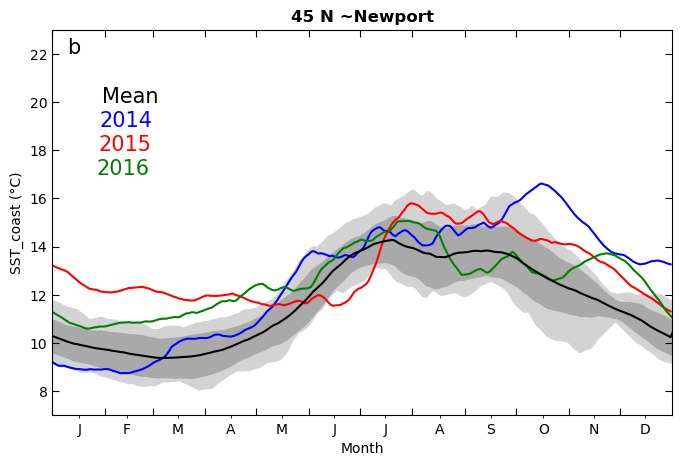

In [6]:
# Smooth with 30 day running mean 
newport_rolling = newport_ds.analysed_sst.rolling(time=30).mean()

# Select year 2014, 2015, 2016
newport_2014 = newport_rolling.sel(time="2014")
newport_2015 = newport_rolling.sel(time="2015")
newport_2016 = newport_rolling.sel(time="2016")

# Change time to day of year
newport_2014["time"] = newport_2014["time.dayofyear"]
newport_2015["time"] = newport_2015["time.dayofyear"]
newport_2016["time"] = newport_2016["time.dayofyear"]

# Create plot
fig, ax = plt.subplots()
fig.set_size_inches(8,5)
ax.grid(False)

# Draw plot lines for 2014, 2015, 2016
newport_2014.plot(ax=ax, ylim=(7,23), color="blue")
newport_2015.plot(ax=ax, ylim=(7,23), color="red")
newport_2016.plot(ax=ax, ylim=(7,23), color="green")

# Draw plot line and shades for mean, max, min, sd for 2002-2013
newport_mean = newport_rolling.sel(time=slice("2002","2013")).groupby("time.dayofyear").mean()
newport_mean.plot(ax=ax,color="black")

newport_max = newport_rolling.sel(time=slice("2002","2013")).groupby("time.dayofyear").max()
newport_min = newport_rolling.sel(time=slice("2002","2013")).groupby("time.dayofyear").min()
ax.fill_between(newport_mean.dayofyear.values, newport_min, newport_max, color="lightgray")

newport_sd = newport_rolling.sel(time=slice("2002", "2013")).groupby("time.dayofyear").std()
sd1 = newport_mean + newport_sd
sd2 = newport_mean - newport_sd
ax.fill_between(newport_mean.dayofyear.values, sd1, sd2, color="darkgray", alpha=1)

# Format ticks
ax.tick_params(color="black", length=5, direction="in", top=True, right=True)
ax.set_xticks([1, 32, 60 , 91, 121, 152, 182, 213, 244, 274, 305, 335])
ax.set_xticklabels('')
ax.set_xticks([17, 45, 75 , 106, 136, 167, 197, 229, 259, 290, 320, 350], minor=True)
ax.set_xticklabels(["J", "F", "M", "A", "M","J", "J", "A", "S", "O", "N", "D"], minor=True)

# Format borders
ax.margins(x=0)
ax.spines[:].set_visible(True)
ax.spines[:].set_color("black")

# Format title and labels
ax.set_title("45 N ~Newport", fontweight="bold")
ax.set_xlabel("Month")
ax.set_ylabel("SST_coast (°C)")
ax.text(30,20, "Mean", fontsize= 15, color="black")
ax.text(29,19, "2014", fontsize= 15, color="blue")
ax.text(28,18, "2015", fontsize= 15, color="red")
ax.text(27,17, "2016", fontsize= 15, color="green")
ax.text(10,22, "b", fontsize= 15, color="black")
plt.show()
fig.savefig('outputs/question6.png')